# Análisis de sentimiento de tweets realizados con el hashtag \#TheSocialDilemma

**Nombre:** Leobardo García Reyes

**Matrícula:** 1616825

# Librerías

In [214]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

import re, string, unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from textblob import TextBlob
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import sentiwordnet as swn

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [216]:
nltk.download('punkt') # Descargar tokenizar
nltk.download('stopwords') # Descargar stopwords
nltk.download('wordnet') # Descargar lematización
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

# Carga de datos

## Lectura de datos

In [217]:
Twitter = pd.read_csv('/content/drive/MyDrive/Tarea 2/TheSocialDilemma.csv')
Twitter.head(3)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,Sentiment
0,Mari Smith,"San Diego, California",Premier Facebook Marketing Expert | Social Med...,2007-09-11 22:22:51,579942,288625,11610,False,2020-09-16 20:55:33,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,NaN,Twitter Web App,False,Neutral
1,Mari Smith,"San Diego, California",Premier Facebook Marketing Expert | Social Med...,2007-09-11 22:22:51,579942,288625,11610,False,2020-09-16 20:53:17,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,NaN,Twitter Web App,False,Neutral
2,Varun Tyagi,"Goa, India",Indian | Tech Solution Artist & Hospitality Ex...,2009-09-06 10:36:01,257,204,475,False,2020-09-16 20:51:57,Go watch “The Social Dilemma” on Netflix!\n\nI...,NaN,Twitter for iPhone,False,Positive


## Manipulación de datos

In [218]:
# Cambio de etiquetas: Positive - Positivo, Negative - Negativo
Twitter['Sentiment'] = Twitter['Sentiment'].replace(['Positive', 'Negative'], ['Positivo', 'Negativo'])

In [219]:
# Dimensión de los datos y nombre de columnas
print('Dimensiones: {}'.format(Twitter.shape))
print('\n')
print(Twitter.columns)

Dimensiones: (20068, 14)


Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet', 'Sentiment'],
      dtype='object')


In [220]:
# Serie de tiempo
tiempo = pd.DataFrame(Twitter[['date']])
tiempo['tweet_dia'] = pd.to_datetime(tiempo['date']).dt.date
tweet_dia = tiempo['tweet_dia'].value_counts().to_frame().reset_index().rename(columns={'index':'date','tweet_dia':'count'})
tweet_dia['date'] = pd.to_datetime(tweet_dia['date'])
tweet_dia = tweet_dia.sort_values('date', ascending = True)
tweet_dia.head(3)

,date,count
25,2020-09-08,16
14,2020-09-09,423
10,2020-09-10,889


Text(0, 0.5, 'Número de tweets')

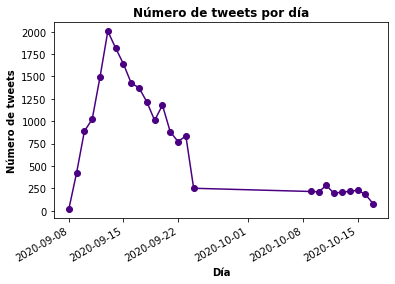

In [221]:
# Gráfico de serie de tiempo
tweet_dia.plot(x = 'date', y = 'count', color = 'indigo', marker = 'o', legend = None)
plt.title('Número de tweets por día', fontweight = 'bold')
plt.xlabel('Día', fontweight = 'bold')
plt.ylabel('Número de tweets', fontweight = 'bold')

# Limpieza de texto

## Primera parte de limpieza de texto

In [222]:
# Función para limpiar texto
def Limpiar_texto(texto):
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()

    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)

    # Eliminación de texto en paréntesis
    nuevo_texto = re.sub('([\(\[]).*?([\)\]])', '\g<1>\g<2>', nuevo_texto)

    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    nuevo_texto = re.sub(r'[^\w\s]', '', nuevo_texto)

    # Eliminación de números
    nuevo_texto = re.sub(r'[0-9]+', ' ', nuevo_texto)

    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub('\\s+', ' ', nuevo_texto)
    
    return(nuevo_texto)

In [223]:
# Seleccionar columnas a utilizar
TText = pd.DataFrame({'texto': Twitter['text'], 'sentimiento': Twitter['Sentiment']})
TText.head(3)

,texto,sentimiento
0,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,Neutral
1,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,Neutral
2,Go watch “The Social Dilemma” on Netflix!\n\nI...,Positivo


In [224]:
# Aplicar la función de limpiza de texto en la columna de texto
TText['texto_limpio'] = TText['texto'].apply(lambda x: Limpiar_texto(x))
TText[['texto', 'sentimiento', 'texto_limpio']].head(3)

,texto,sentimiento,texto_limpio
0,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,Neutral,musicmadmarc socialdilemma netflix facebook i...
1,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,Neutral,musicmadmarc socialdilemma netflix facebook h...
2,Go watch “The Social Dilemma” on Netflix!\n\nI...,Positivo,go watch the social dilemma on netflix its the...


## Stopwords

In [225]:
# Stopwords en ingles
sw = stopwords.words('english')

# Nuevas stopwords
nuevas_sw = ('one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'im', 'dont', 'us')

for i in nuevas_sw:
    sw.append(i)

print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Diccionario POS

In [226]:
# Diccionario de etiquetado POS
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

# Función que etiqueta cada palabra con verbo, sustantivo, adjetivo, adverbio
# También remueve las stopwords
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in sw:
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return(newlist)

TText['texto_pos'] = TText['texto_limpio'].apply(token_stop_pos)
TText.head(3)

,texto,sentimiento,texto_limpio,texto_pos
0,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,Neutral,musicmadmarc socialdilemma netflix facebook i...,"[(musicmadmarc, n), (socialdilemma, n), (netfl..."
1,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,Neutral,musicmadmarc socialdilemma netflix facebook h...,"[(musicmadmarc, n), (socialdilemma, n), (netfl..."
2,Go watch “The Social Dilemma” on Netflix!\n\nI...,Positivo,go watch the social dilemma on netflix its the...,"[(go, v), (watch, v), (social, a), (dilemma, n..."


## Lematización

In [227]:
# Método Lematizar
wordnet_lemmatizer = WordNetLemmatizer()

# Función para lematizar cada palabra
def lemmatize(pos_data):
    lemma_rew = ' '
    for word, pos in pos_data:
        if not pos: 
            lemma = word
            lemma_rew = lemma_rew + ' ' + lemma
        else:  
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + ' ' + lemma
    return(lemma_rew)
    
TText['lema'] = TText['texto_pos'].apply(lemmatize)
TText.head(3)

,texto,sentimiento,texto_limpio,texto_pos,lema
0,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,Neutral,musicmadmarc socialdilemma netflix facebook i...,"[(musicmadmarc, n), (socialdilemma, n), (netfl...",musicmadmarc socialdilemma netflix facebook ...
1,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,Neutral,musicmadmarc socialdilemma netflix facebook h...,"[(musicmadmarc, n), (socialdilemma, n), (netfl...",musicmadmarc socialdilemma netflix facebook ...
2,Go watch “The Social Dilemma” on Netflix!\n\nI...,Positivo,go watch the social dilemma on netflix its the...,"[(go, v), (watch, v), (social, a), (dilemma, n...",go watch social dilemma netflix best minute ...


In [228]:
def mayores(texto):
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()

    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')

    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    return(nuevo_texto)

TText['mayores'] = TText['lema'].apply(mayores)
TText.head(3)

,texto,sentimiento,texto_limpio,texto_pos,lema,mayores
0,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,Neutral,musicmadmarc socialdilemma netflix facebook i...,"[(musicmadmarc, n), (socialdilemma, n), (netfl...",musicmadmarc socialdilemma netflix facebook ...,"[musicmadmarc, socialdilemma, netflix, faceboo..."
1,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,Neutral,musicmadmarc socialdilemma netflix facebook h...,"[(musicmadmarc, n), (socialdilemma, n), (netfl...",musicmadmarc socialdilemma netflix facebook ...,"[musicmadmarc, socialdilemma, netflix, faceboo..."
2,Go watch “The Social Dilemma” on Netflix!\n\nI...,Positivo,go watch the social dilemma on netflix its the...,"[(go, v), (watch, v), (social, a), (dilemma, n...",go watch social dilemma netflix best minute ...,"[go, watch, social, dilemma, netflix, best, mi..."


In [229]:
def lema_mayores(texto):
    juntar = ' '
    for word in texto:
        juntar = juntar + ' ' + word
    return juntar

TText['lema_mayores'] = TText['mayores'].apply(lema_mayores)
TText.head(3)

,texto,sentimiento,texto_limpio,texto_pos,lema,mayores,lema_mayores
0,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,Neutral,musicmadmarc socialdilemma netflix facebook i...,"[(musicmadmarc, n), (socialdilemma, n), (netfl...",musicmadmarc socialdilemma netflix facebook ...,"[musicmadmarc, socialdilemma, netflix, faceboo...",musicmadmarc socialdilemma netflix facebook ...
1,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,Neutral,musicmadmarc socialdilemma netflix facebook h...,"[(musicmadmarc, n), (socialdilemma, n), (netfl...",musicmadmarc socialdilemma netflix facebook ...,"[musicmadmarc, socialdilemma, netflix, faceboo...",musicmadmarc socialdilemma netflix facebook ...
2,Go watch “The Social Dilemma” on Netflix!\n\nI...,Positivo,go watch the social dilemma on netflix its the...,"[(go, v), (watch, v), (social, a), (dilemma, n...",go watch social dilemma netflix best minute ...,"[go, watch, social, dilemma, netflix, best, mi...",go watch social dilemma netflix best minute ...


In [230]:
Texto_final = TText.loc[:, ['texto', 'sentimiento', 'lema_mayores']]
Texto_final.head(3)

,texto,sentimiento,lema_mayores
0,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,Neutral,musicmadmarc socialdilemma netflix facebook ...
1,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,Neutral,musicmadmarc socialdilemma netflix facebook ...
2,Go watch “The Social Dilemma” on Netflix!\n\nI...,Positivo,go watch social dilemma netflix best minute ...


Text(0.5, 1.0, 'Tipo de sentimiento de cada tweet')

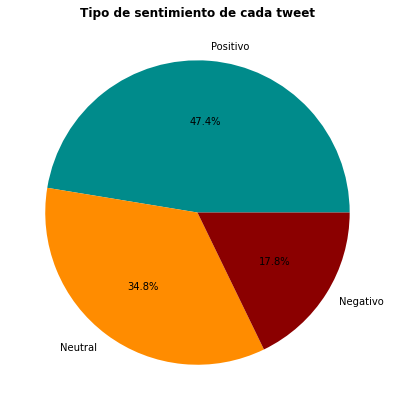

In [231]:
texto_count = Texto_final['sentimiento'].value_counts()
color = ['darkcyan', 'darkorange', 'darkred']
plt.figure(figsize = (10, 7))
plt.pie(texto_count.values, labels = texto_count.index, autopct = '%1.1f%%', shadow = False, colors = color)
plt.title('Tipo de sentimiento de cada tweet', fontweight = 'bold')

# Análisis de sentimiento

## Análisis de sentimiento usando TextBlob

In [232]:
# function to calculate subjectivity 
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

# function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negativo'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positivo'

In [233]:
text_blob = pd.DataFrame(Texto_final[['texto', 'lema_mayores']])

text_blob['Subjectivity'] = text_blob['lema_mayores'].apply(getSubjectivity) 
text_blob['Polarity'] = text_blob['lema_mayores'].apply(getPolarity) 
text_blob['sentimiento'] = text_blob['Polarity'].apply(analysis)
text_blob.head(3)

,texto,lema_mayores,Subjectivity,Polarity,sentimiento
0,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,musicmadmarc socialdilemma netflix facebook ...,0.250000,0.000000,Neutral
1,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,musicmadmarc socialdilemma netflix facebook ...,0.000000,0.000000,Neutral
2,Go watch “The Social Dilemma” on Netflix!\n\nI...,go watch social dilemma netflix best minute ...,0.183333,0.516667,Positivo


Text(0, 0.5, 'Subjetividad')

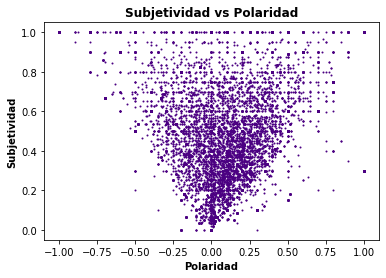

In [234]:
x = text_blob['Polarity'].values
y = text_blob['Subjectivity'].values
plt.plot(x, y, 'o', color='indigo', markersize = 1)
plt.title('Subjetividad vs Polaridad', fontweight = 'bold')
plt.xlabel('Polaridad', fontweight = 'bold')
plt.ylabel('Subjetividad', fontweight = 'bold')

Text(0.5, 1.0, 'Tipo de sentimiento de cada tweet TEXTBLOB')

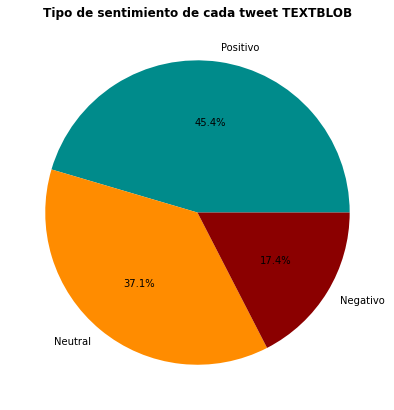

In [235]:
tb_count = text_blob['sentimiento'].value_counts()
color = ['darkcyan', 'darkorange', 'darkred']
plt.figure(figsize = (10, 7))
plt.pie(tb_count.values, labels = tb_count.index, autopct = '%1.1f%%', shadow = False, colors = color)
plt.title('Tipo de sentimiento de cada tweet TEXTBLOB', fontweight = 'bold')

## Análisis de sentimiento usando VADER

In [236]:
analyzer = SentimentIntensityAnalyzer()

# function to calculate vader sentiment  
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

vader = pd.DataFrame(Texto_final[['texto', 'lema_mayores']])
vader['Vader Sentiment'] = vader['lema_mayores'].apply(vadersentimentanalysis)

In [237]:
# function to analyse 
def vader_analysis(compound):
    if compound >= 0.2:
        return 'Positivo'
    elif compound <= -0.2:
        return 'Negativo'
    else:
        return 'Neutral'
    
vader['sentimiento'] = vader['Vader Sentiment'].apply(vader_analysis)
vader.head(3)

,texto,lema_mayores,Vader Sentiment,sentimiento
0,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,musicmadmarc socialdilemma netflix facebook ...,0.0000,Neutral
1,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,musicmadmarc socialdilemma netflix facebook ...,0.3612,Positivo
2,Go watch “The Social Dilemma” on Netflix!\n\nI...,go watch social dilemma netflix best minute ...,0.5423,Positivo


Text(0, 0.5, 'Compuesto VADER')

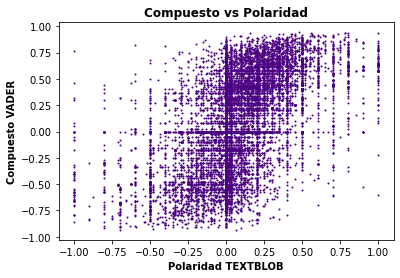

In [238]:
x = text_blob['Polarity'].values
y = vader['Vader Sentiment'].values
plt.plot(x, y, 'o', color='indigo', markersize = 1)
plt.title('Compuesto vs Polaridad', fontweight = 'bold')
plt.xlabel('Polaridad TEXTBLOB', fontweight = 'bold')
plt.ylabel('Compuesto VADER', fontweight = 'bold')

Text(0.5, 1.0, 'Tipo de sentimiento de cada tweet VADER')

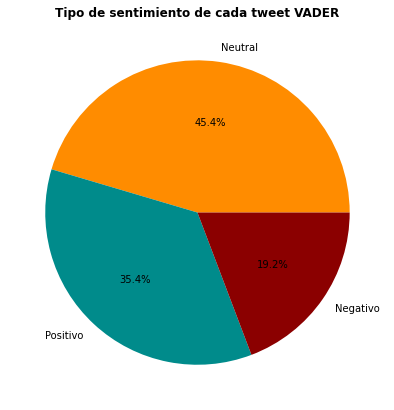

In [239]:
vader_count = vader['sentimiento'].value_counts()
color = ['darkorange', 'darkcyan', 'darkred']
plt.figure(figsize = (10, 7))
plt.pie(vader_count.values, labels = vader_count.index, autopct = '%1.1f%%', shadow = False, colors = color)
plt.title('Tipo de sentimiento de cada tweet VADER', fontweight = 'bold')

## Análisis de sentimiento usando SentiWordNet

In [240]:
def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos = pos)
        if not lemma:
            continue
        
        synsets = wordnet.synsets(lemma, pos = pos)
        if not synsets:
            continue

        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
        # print(swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score())
    if not tokens_count:
        return 0
    if sentiment > 0:
        return "Positivo"
    if sentiment == 0:
        return "Neutral"
    else:
        return "Negativo"

SWNet = pd.DataFrame(Texto_final[['texto', 'lema_mayores']])
SWNet['sentimiento'] = TText['texto_pos'].apply(sentiwordnetanalysis)
SWNet.to_csv('/content/drive/MyDrive/Tarea 2/SWNET.csv', header = True, index = False)
SWNet.head()

,texto,lema_mayores,sentimiento
0,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,musicmadmarc socialdilemma netflix facebook ...,Positivo
1,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,musicmadmarc socialdilemma netflix facebook ...,Positivo
2,Go watch “The Social Dilemma” on Netflix!\n\nI...,go watch social dilemma netflix best minute ...,Positivo
3,I watched #TheSocialDilemma last night. I’m sc...,watch thesocialdilemma last night scar human...,Neutral
4,The problem of me being on my phone most the t...,problem phone time try watch thesocialdilemma,Negativo


Text(0.5, 1.0, 'Tipo de sentimiento de cada tweet SENTIWORDNET')

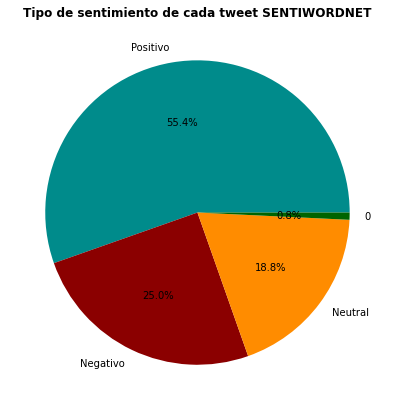

In [241]:
SWNet_count = SWNet['sentimiento'].value_counts()
color = ['darkcyan', 'darkred', 'darkorange', 'darkgreen']
plt.figure(figsize = (10, 7))
plt.pie(SWNet_count.values, labels = SWNet_count.index, autopct = '%1.1f%%', shadow = False, colors = color)
plt.title('Tipo de sentimiento de cada tweet SENTIWORDNET', fontweight = 'bold')

# Gráficos de frecuencias y nube de palabras

In [242]:
# Juntar todas las palabras en una sola lista
# Texto_final['lema_mayores']
# text_blob['lema_mayores']
# vader['lema_mayores']
# SWNet['lema_mayores']
# filtro['lema_mayores']

filtro = SWNet[(SWNet['sentimiento'] == 0)]
texto_analizar = filtro['lema_mayores']
tokenizar = [cadena.split() for cadena in texto_analizar]
descripcion = []
for cadena in tokenizar:
    for i in cadena:
        descripcion.append(i)

descripcion[:5]

['wokewashing', 'thesocialdilemma', 'nonton', 'thesocialdilemma', 'netflix']

In [243]:
texto_analizar

83                            wokewashing thesocialdilemma
87                         nonton thesocialdilemma netflix
381        thesocialdilemma thesocialdilemma thesociald...
516                               thesocialdilemma netflix
716                               thesocialdilemma netflix
                               ...                        
19095        rundown jockumhilden thesocialdilemma targeti
19445      techteachertom commonsenseed commonsense app...
19614                    assistam thesocialdilemma netflix
19906             idaaa om netflix serien thesocialdilemma
19913                             thesocialdilemma netflix
Name: lema_mayores, Length: 153, dtype: object

## Gráfico de frecuencias de palabras

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 120374 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 120372 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 120374 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 120372 missing from current font.
  font.set_text(s, 0, flags=flags)


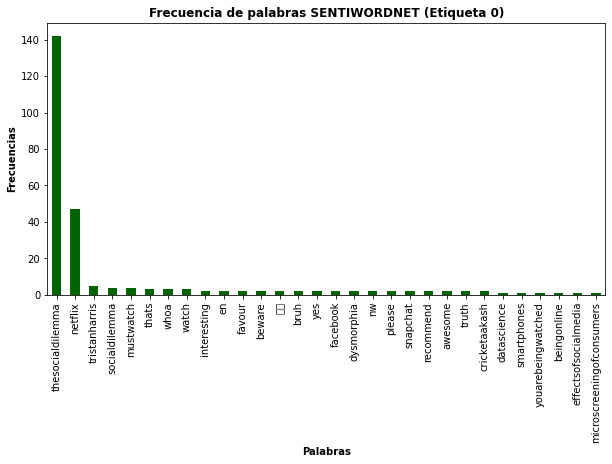

In [244]:
def gra_pa(datos, titulo = None):
    aux = pd.Series(datos)
    aux.value_counts()[:30].plot.bar(figsize = (10, 5), color = 'darkgreen')
    if titulo: 
        plt.title(titulo, fontweight = 'bold')
    plt.xlabel('Palabras', fontweight = 'bold')
    plt.ylabel('Frecuencias', fontweight = 'bold')

gra_pa(descripcion, titulo = 'Frecuencia de palabras SENTIWORDNET (Etiqueta 0)')

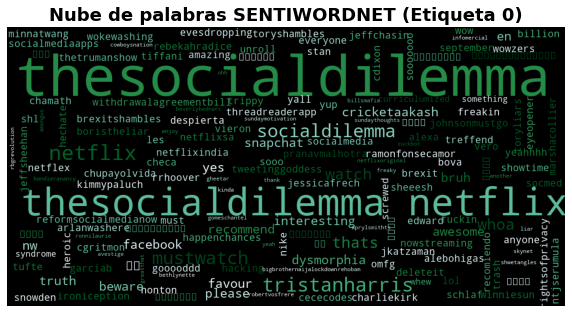

In [245]:
# Generar nube de palabras
# BuPu_r - general
# PuBu_r - positivo
# Reds_r - negativo
# YlOrBr_r - neutral
# BuGn_r - 0
metodo = texto_analizar
unir = ''
for cadena in metodo:
    aux = cadena.lower().split()
    unir += " ".join(aux)+" "

def mostrar_nube(unir, titulo = None):
    wordcloud = WordCloud(
        background_color = 'black', colormap= 'BuGn_r',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 1
    ).generate(unir)
    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if titulo: 
        plt.title(titulo, fontweight = 'bold', fontsize = 18)
    plt.imshow(wordcloud)
    plt.show()

mostrar_nube(unir, titulo = 'Nube de palabras SENTIWORDNET (Etiqueta 0)')

# Aprendizaje Automático

In [246]:
features = Texto_final.iloc[:, 2].values
labels = Texto_final.iloc[:, 1].values


In [247]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))
    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [248]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [249]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [250]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [251]:
predictions = text_classifier.predict(X_test)

In [252]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[ 368  146  190]
 [  34 1236   56]
 [  59  217 1708]]
              precision    recall  f1-score   support

    Negativo       0.80      0.52      0.63       704
     Neutral       0.77      0.93      0.85      1326
    Positivo       0.87      0.86      0.87      1984

    accuracy                           0.83      4014
   macro avg       0.82      0.77      0.78      4014
weighted avg       0.83      0.83      0.82      4014

0.8251121076233184
